In [3]:
import numpy as np

rows = np.loadtxt("./lotto_lstm.csv", delimiter=",")
row_count = len(rows)

print("row count: ", str(row_count))

row count:  991


In [15]:
# 당첨번호를 원핫인코딩벡터(ohbin)으로 변환
def numbers2ohbin(numbers):
  ohbin = np.zeros(45) #45개의 빈칸

  for i in range(6): 
    ohbin[int(numbers[i])-1] = 1
  
  return ohbin


# 원핫인코딩벡터(ohbin)를 번호로 변환
def ohbin2numbers(ohbin):

    numbers = []
    
    for i in range(len(ohbin)):
        if ohbin[i] == 1.0: # 1.0으로 설정되어 있으면 해당 번호를 반환값에 추가한다.
            numbers.append(i+1)
    
    return numbers

In [16]:
numbers = rows[:, 1:7]
ohbins = list(map(numbers2ohbin, numbers))

x_samples = ohbins[0:row_count-1]
y_samples = ohbins[1: row_count]

print("ohbins")
print("X[0]: " + str(x_samples[0]))
print("Y[0]: " + str(y_samples[0]))

#번호로 표시
print("numbers")
print("X[0]: " + str(ohbin2numbers(x_samples[0])))
print("Y[0]: " + str(ohbin2numbers(y_samples[0])))

ohbins
X[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
Y[0]: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
numbers
X[0]: [10, 23, 29, 33, 37, 40]
Y[0]: [9, 13, 21, 25, 32, 42]


In [17]:
train_idx = (0, 700)
val_idx = (700, 800)
test_idx = (800, len(x_samples))

print("train: {0}, val: {1}, test: {2}".format(train_idx, val_idx, test_idx))

train: (0, 700), val: (700, 800), test: (800, 990)


In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

In [20]:
# define the MODEL
model = keras.Sequential([keras.layers.LSTM(128, batch_input_shape=(1,1,45), return_sequences=False, stateful=True), keras.layers.Dense(45, activation="sigmoid")])

In [21]:
# compile the MODEL
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

In [31]:
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(100):
  model.reset_states()

  batch_train_loss = []
  batch_train_acc = []

  for i in range(train_idx[0], train_idx[1]):
    xs = x_samples[i].reshape(1, 1, 45)
    ys = y_samples[i].reshape(1, 45)

    loss, acc = model.train_on_batch(xs, ys)

    batch_train_loss.append(loss)
    batch_train_acc.append(acc)
  
    train_loss.append(np.mean(batch_train_loss))
    train_acc.append(np.mean(batch_train_acc))

    batch_val_loss = []
    batch_val_acc = []

    for i in range(val_idx[0], val_idx[1]):

        xs = x_samples[i].reshape(1, 1, 45)
        ys = y_samples[i].reshape(1, 45)
        
        loss, acc = model.test_on_batch(xs, ys) #배치만큼 모델에 입력하여 나온 답을 정답과 비교함
        
        batch_val_loss.append(loss)
        batch_val_acc.append(acc)

    val_loss.append(np.mean(batch_val_loss))
    val_acc.append(np.mean(batch_val_acc))

    print('epoch {0:4d} train acc {1:0.3f} loss {2:0.3f} val acc {3:0.3f} loss {4:0.3f}'.format(epoch, np.mean(batch_train_acc), np.mean(batch_train_loss), np.mean(batch_val_acc), np.mean(batch_val_loss)))

    model.save('model_{0:04d}.h5'.format(epoch+1))

epoch    0 train acc 1.000 loss 0.592 val acc 0.000 loss 0.399
epoch    0 train acc 0.500 loss 0.484 val acc 0.000 loss 0.396
epoch    0 train acc 0.333 loss 0.449 val acc 0.000 loss 0.396
epoch    0 train acc 0.250 loss 0.434 val acc 0.000 loss 0.396
epoch    0 train acc 0.200 loss 0.425 val acc 0.000 loss 0.396
epoch    0 train acc 0.167 loss 0.423 val acc 0.000 loss 0.396
epoch    0 train acc 0.143 loss 0.417 val acc 0.000 loss 0.396
epoch    0 train acc 0.125 loss 0.415 val acc 0.000 loss 0.396
epoch    0 train acc 0.111 loss 0.416 val acc 0.000 loss 0.396


KeyboardInterrupt: 

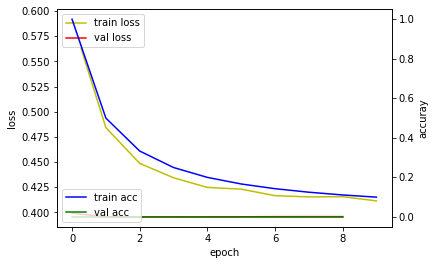

In [32]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(train_loss, 'y', label='train loss')
loss_ax.plot(val_loss, 'r', label='val loss')

acc_ax.plot(train_acc, 'b', label='train acc')
acc_ax.plot(val_acc, 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [30]:
def gen_numbers_from_probability(nums_prob):

    ball_box = []

    for n in range(45):
        ball_count = int(nums_prob[n] * 100 + 1)
        ball = np.full((ball_count), n+1) #1부터 시작
        ball_box += list(ball)

    selected_balls = []

    while True:
        
        if len(selected_balls) == 6:
            break
        
        ball_index = np.random.randint(len(ball_box), size=1)[0]
        ball = ball_box[ball_index]

        if ball not in selected_balls:
            selected_balls.append(ball)

    return selected_balls

# 마지막 회차까지 학습한 모델로 다음 회차 추론

print('receive numbers')

xs = x_samples[-1].reshape(1, 1, 45)

ys_pred = model.predict_on_batch(xs)

list_numbers = []

for n in range(10):
    numbers = gen_numbers_from_probability(ys_pred[0])
    numbers.sort()
    print('{0} : {1}'.format(n, numbers))
    list_numbers.append(numbers)  

receive numbers
0 : [4, 5, 6, 9, 37, 44]
1 : [12, 19, 35, 40, 42, 44]
2 : [12, 14, 24, 31, 32, 37]
3 : [8, 18, 24, 40, 42, 45]
4 : [12, 21, 24, 29, 38, 40]
5 : [8, 13, 22, 26, 35, 38]
6 : [11, 14, 30, 32, 42, 45]
7 : [1, 9, 19, 22, 24, 25]
8 : [2, 13, 17, 19, 30, 41]
9 : [3, 17, 21, 23, 38, 40]
